In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)  # Display full content of each column
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.width', 5000)         # Set display width

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df=pd.read_csv("features.csv")
df.columns

Index(['Transaction Date', 'Description', 'Reference No./Cheque No.', 'Debit', 'Credit', 'Balance', 'Transaction Type', 'Transaction Mode', 'DR/CR Indicator', 'Transaction ID', 'Recipient Name', 'Bank', 'UPI ID', 'Note', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'is_weekend', 'transaction_amount', 'is_large_transaction', 'Balance.1'], dtype='object')

In [23]:
import pandas as pd
import numpy as np

missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])


Missing values in each column:
 Reference No./Cheque No.     21
Transaction Mode             22
Transaction ID               34
Recipient Name               34
Bank                        111
UPI ID                      111
Note                         52
dtype: int64


In [10]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_summary = df[numerical_cols].describe()
numerical_summary


,Debit,Credit,Balance,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,transaction_amount,is_large_transaction,Balance.1
count,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000
mean,295.891903,296.845412,1619.971835,2.916329,2.601889,6.811066,2023.311741,191.715250,15.512821,27.730094,0.271255,295.891903,0.024291,1619.971835
std,3657.558653,3698.509961,3876.740810,2.009038,0.959700,2.934775,0.631373,89.065637,8.606497,12.700608,0.444908,3657.558653,0.154057,3876.740810
min,0.000000,0.000000,12.790000,0.000000,1.000000,1.000000,2022.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,12.790000
25%,0.000000,0.000000,798.920000,1.000000,2.000000,4.000000,2023.000000,120.000000,8.000000,18.000000,0.000000,0.000000,0.000000,798.920000
50%,56.000000,0.000000,1214.820000,3.000000,2.000000,6.000000,2023.000000,172.000000,16.000000,25.000000,0.000000,56.000000,0.000000,1214.820000
75%,167.000000,10.000000,1753.820000,5.000000,3.000000,9.000000,2024.000000,269.000000,23.000000,39.000000,1.000000,167.000000,0.000000,1753.820000
max,99069.800000,100000.000000,101359.590000,6.000000,4.000000,12.000000,2024.000000,365.000000,31.000000,52.000000,1.000000,99069.800000,1.000000,101359.590000


In [25]:
from prettytable import PrettyTable
# Detecting Outliers using IQR method
def detect_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = col[(col < lower_bound) | (col > upper_bound)]
    return outliers

outlier_dict = {}
for col in numerical_cols:
    outliers = detect_outliers(df[col])
    outlier_dict[col] = len(outliers)



table = PrettyTable()
table.field_names = ["Numerical Column", "Number of Outliers"]

for col, outlier_count in outlier_dict.items():
    table.add_row([col, outlier_count])

print(table)


+----------------------+--------------------+
|   Numerical Column   | Number of Outliers |
+----------------------+--------------------+
|        Debit         |         71         |
|        Credit        |        171         |
|       Balance        |         51         |
|      dayofweek       |         0          |
|       quarter        |         0          |
|        month         |         0          |
|         year         |         0          |
|      dayofyear       |         0          |
|      dayofmonth      |         0          |
|      weekofyear      |         0          |
|      is_weekend      |         0          |
|  transaction_amount  |         71         |
| is_large_transaction |         18         |
|      Balance.1       |         51         |
+----------------------+--------------------+


In [21]:

# Categorical column analysis
categorical_cols = df.select_dtypes(include=['object']).columns
distinct_counts = {col: df[col].nunique() for col in categorical_cols}
most_frequent = {col: df[col].value_counts().idxmax() for col in categorical_cols}
from prettytable import PrettyTable

# Create a table for the categorical column analysis
table = PrettyTable()

# Set the table field names
table.field_names = ["Categorical Column", "Distinct Values", "Most Frequent Value"]

# Add rows to the table
for col in categorical_cols:
    table.add_row([col, distinct_counts[col], most_frequent[col]])

# Display the table
print(table)


+--------------------------+-----------------+--------------------------+
|    Categorical Column    | Distinct Values |   Most Frequent Value    |
+--------------------------+-----------------+--------------------------+
|     Transaction Date     |       360       |        2024-06-16        |
|       Description        |       731       |    CREDIT INTEREST--     |
| Reference No./Cheque No. |       224       | TRANSFER TO4897692162094 |
|     Transaction Type     |        2        |            TO            |
|     Transaction Mode     |        4        |           UPI            |
|     DR/CR Indicator      |        2        |            DR            |
|      Transaction ID      |       647       |        9890160567        |
|      Recipient Name      |       249       |          XX8237          |
|           Bank           |        28       |           YESB           |
|          UPI ID          |       250       |        paytmqr281        |
|           Note           |        64

In [16]:
# Correlation matrix of numerical features
correlation_matrix = df[numerical_cols].corr()
correlation_matrix


,Debit,Credit,Balance,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,transaction_amount,is_large_transaction,Balance.1
Debit,1.000000,-0.006502,0.007096,0.055722,0.013009,-0.002454,0.047788,-0.002979,-0.005976,-0.003904,0.062050,1.000000,0.305561,0.007096
Credit,-0.006502,1.000000,0.956587,0.057440,0.013648,-0.001385,0.045730,-0.002663,-0.013850,-0.003641,0.062077,-0.006502,-0.012673,0.956587
Balance,0.007096,0.956587,1.000000,0.035866,-0.024782,-0.059680,0.059479,-0.063912,-0.043084,-0.064416,0.042950,0.007096,0.027685,1.000000
dayofweek,0.055722,0.057440,0.035866,1.000000,-0.003983,0.012213,-0.020958,0.013257,0.008346,-0.009466,0.788913,0.055722,0.045871,0.035866
quarter,0.013009,0.013648,-0.024782,-0.003983,1.000000,0.959722,-0.200801,0.956769,-0.074723,0.957170,-0.018925,0.013009,0.038078,-0.024782
month,-0.002454,-0.001385,-0.059680,0.012213,0.959722,1.000000,-0.245305,0.995349,-0.092248,0.995137,-0.000025,-0.002454,0.010165,-0.059680
year,0.047788,0.045730,0.059479,-0.020958,-0.200801,-0.245305,1.000000,-0.253100,-0.109040,-0.245984,-0.007985,0.047788,0.005400,0.059479
dayofyear,-0.002979,-0.002663,-0.063912,0.013257,0.956769,0.995349,-0.253100,1.000000,0.003844,0.999718,-0.000708,-0.002979,0.012619,-0.063912
dayofmonth,-0.005976,-0.013850,-0.043084,0.008346,-0.074723,-0.092248,-0.109040,0.003844,1.000000,0.002888,-0.007085,-0.005976,0.025245,-0.043084
weekofyear,-0.003904,-0.003641,-0.064416,-0.009466,0.957170,0.995137,-0.245984,0.999718,0.002888,1.000000,-0.018594,-0.003904,0.011643,-0.064416


In [17]:
print("Start date:", df['Transaction Date'].min())
print("End date:", df['Transaction Date'].max())

Start date: 2022-05-31
End date: 2024-11-06


In [6]:
print("Min transaction amount:", df['transaction_amount'].min())
print("Max transaction amount:", df['transaction_amount'].max())

Min transaction amount: 0.0
Max transaction amount: 99069.8


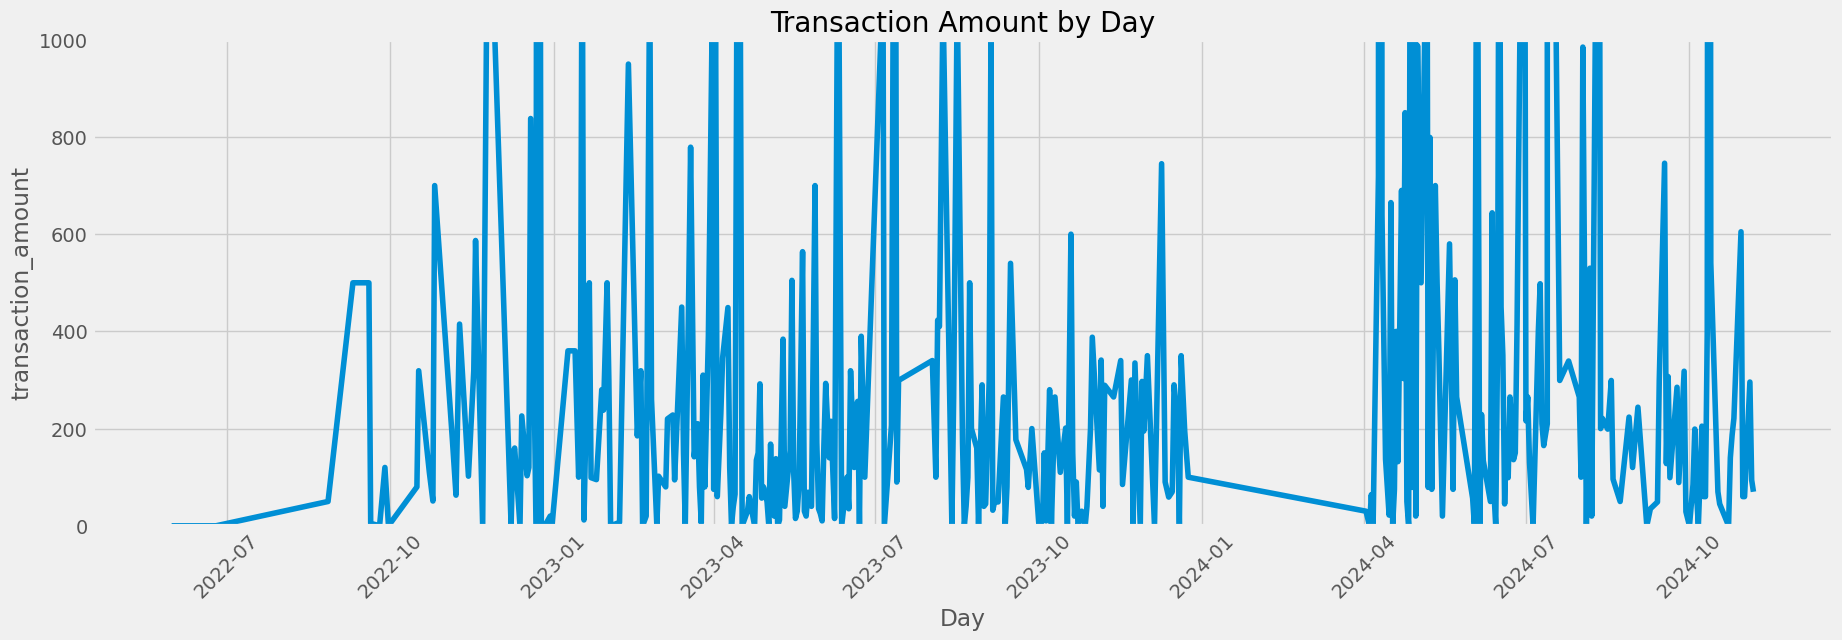

In [37]:
# 1. Daily Transaction Amount Distribution
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Day'] = df['Transaction Date'].dt.date

daily_transactions = df.groupby('Day')['transaction_amount'].sum().reset_index()

plt.figure(figsize=(20, 6))
sns.lineplot(x='Day', y='transaction_amount', data=daily_transactions)
plt.title('Transaction Amount by Day')
plt.xticks(rotation=45)
plt.ylim(0, 1000)  # Adjust the y-axis to a suitable range for daily transactions
plt.show()


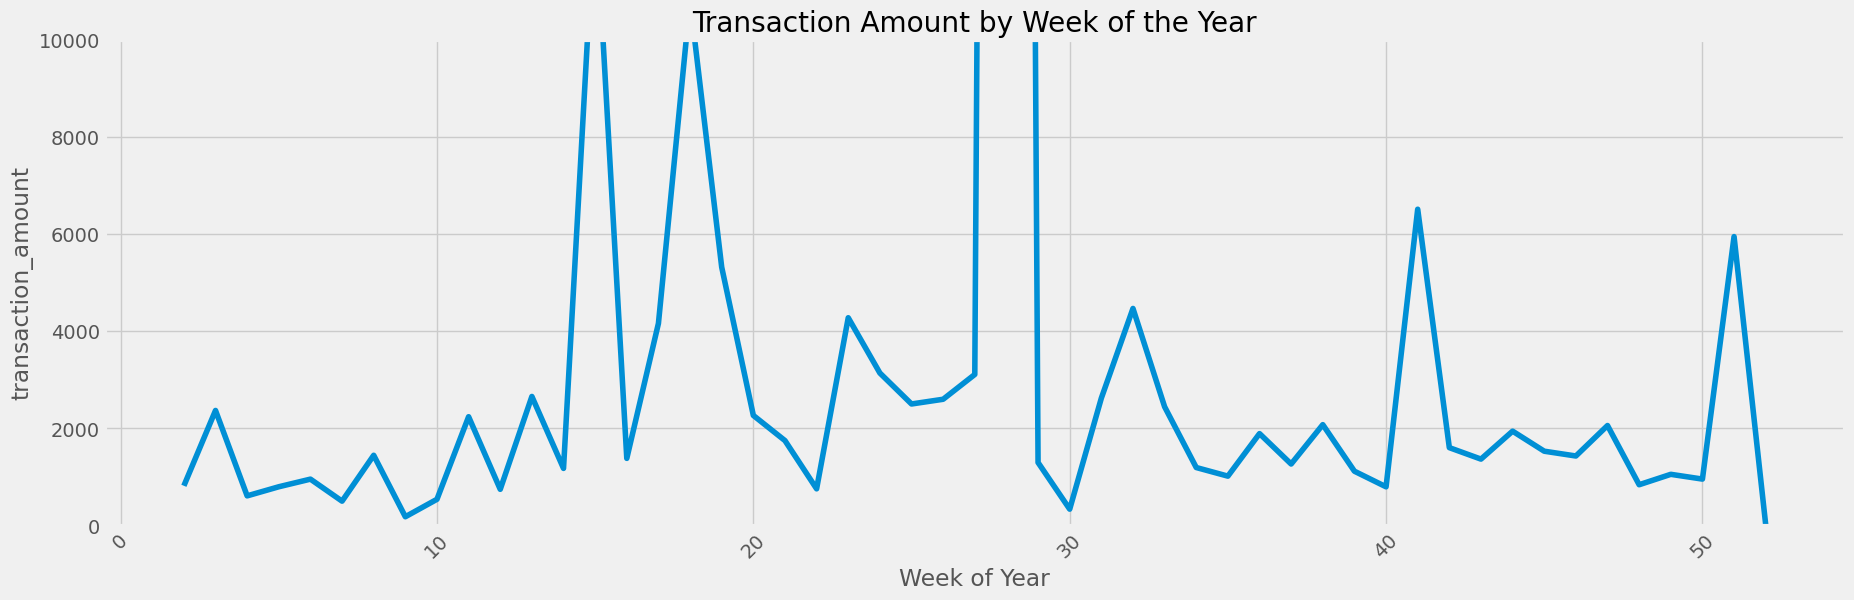

In [43]:
# 2. Weekly Transaction Amount Distribution
df['Week of Year'] = df['Transaction Date'].dt.isocalendar().week

weekly_transactions = df.groupby('Week of Year')['transaction_amount'].sum().reset_index()

plt.figure(figsize=(20, 6))
sns.lineplot(x='Week of Year', y='transaction_amount', data=weekly_transactions)
plt.title('Transaction Amount by Week of the Year')
plt.xticks(rotation=45)
plt.ylim(0, 10000)  # Adjust y-axis limits to fit the range of weekly transactions
plt.show()


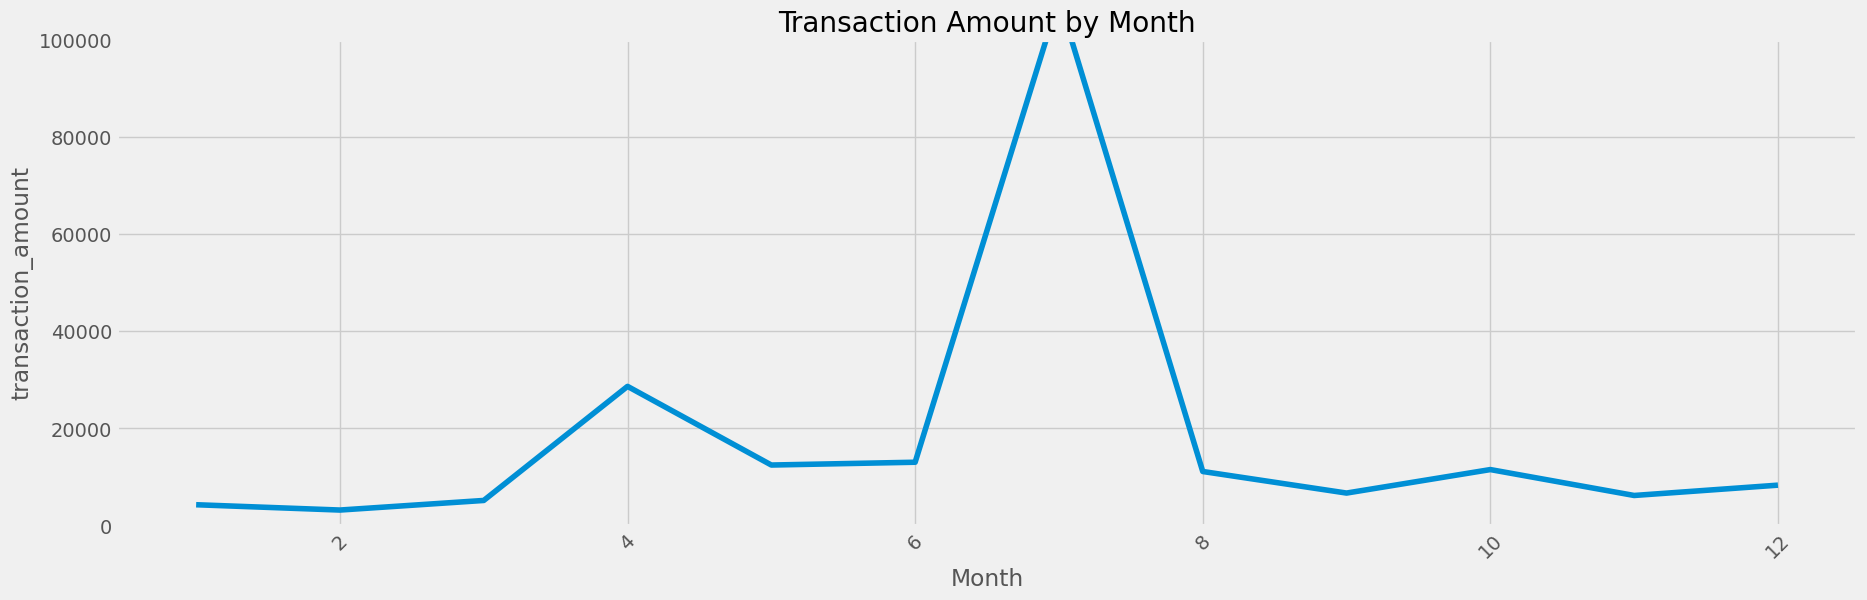

In [46]:
# 3. Monthly Transaction Amount Distribution
df['Month'] = df['Transaction Date'].dt.month

monthly_transactions = df.groupby('Month')['transaction_amount'].sum().reset_index()

plt.figure(figsize=(20, 6))
sns.lineplot(x='Month', y='transaction_amount', data=monthly_transactions)
plt.title('Transaction Amount by Month')
plt.xticks(rotation=45)
plt.ylim(0, 100000)  # Adjust y-axis limits to fit the range of monthly transactions
plt.show()


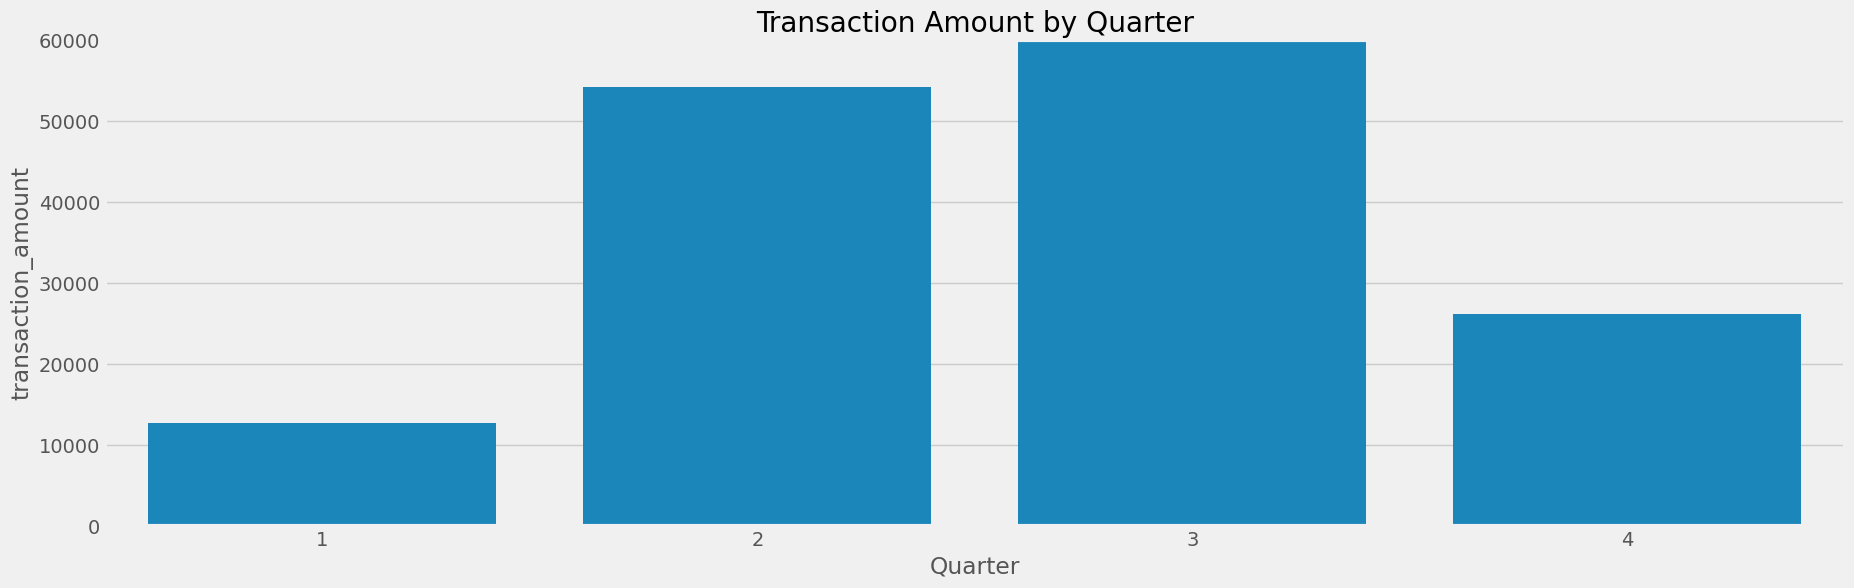

In [52]:
# 4. Quarterly Transaction Amount Distribution
df['Quarter'] = df['Transaction Date'].dt.quarter

quarterly_transactions = df.groupby('Quarter')['transaction_amount'].sum().reset_index()

plt.figure(figsize=(20, 6))
sns.barplot(x='Quarter', y='transaction_amount', data=quarterly_transactions)
plt.title('Transaction Amount by Quarter')
plt.ylim(0, 60000)  # Adjust y-axis limits to fit the range of quarterly transactions
plt.show()


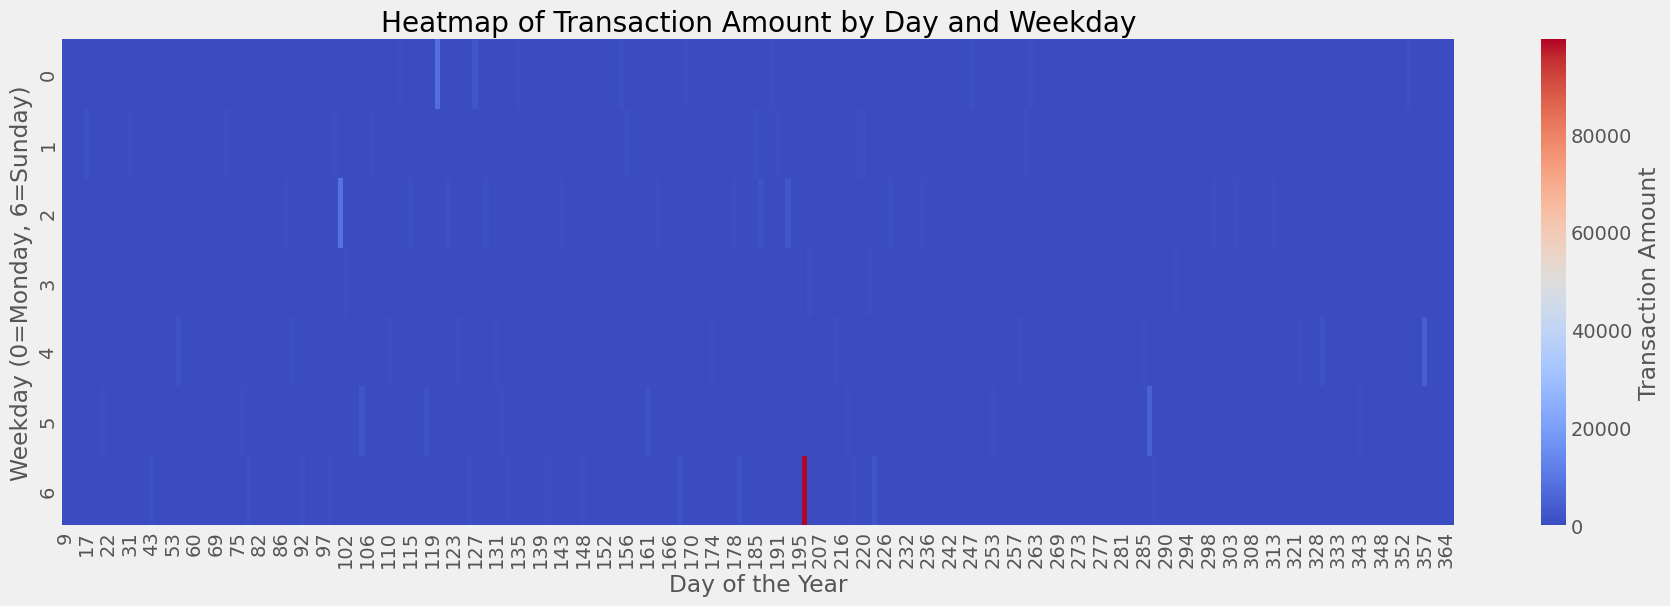

In [53]:
# 5. Heatmap: Transaction Amount by Day of the Week and Week of the Year
df['Weekday'] = df['Transaction Date'].dt.weekday
df['Day of Year'] = df['Transaction Date'].dt.dayofyear

# Pivot table for heatmap
heatmap_data = df.pivot_table(values='transaction_amount', index='Weekday', columns='Day of Year', aggfunc='sum', fill_value=0)

plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Transaction Amount'})
plt.title('Heatmap of Transaction Amount by Day and Weekday')
plt.xlabel('Day of the Year')
plt.ylabel('Weekday (0=Monday, 6=Sunday)')
plt.show()


Prophet
--

04:44:41 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing


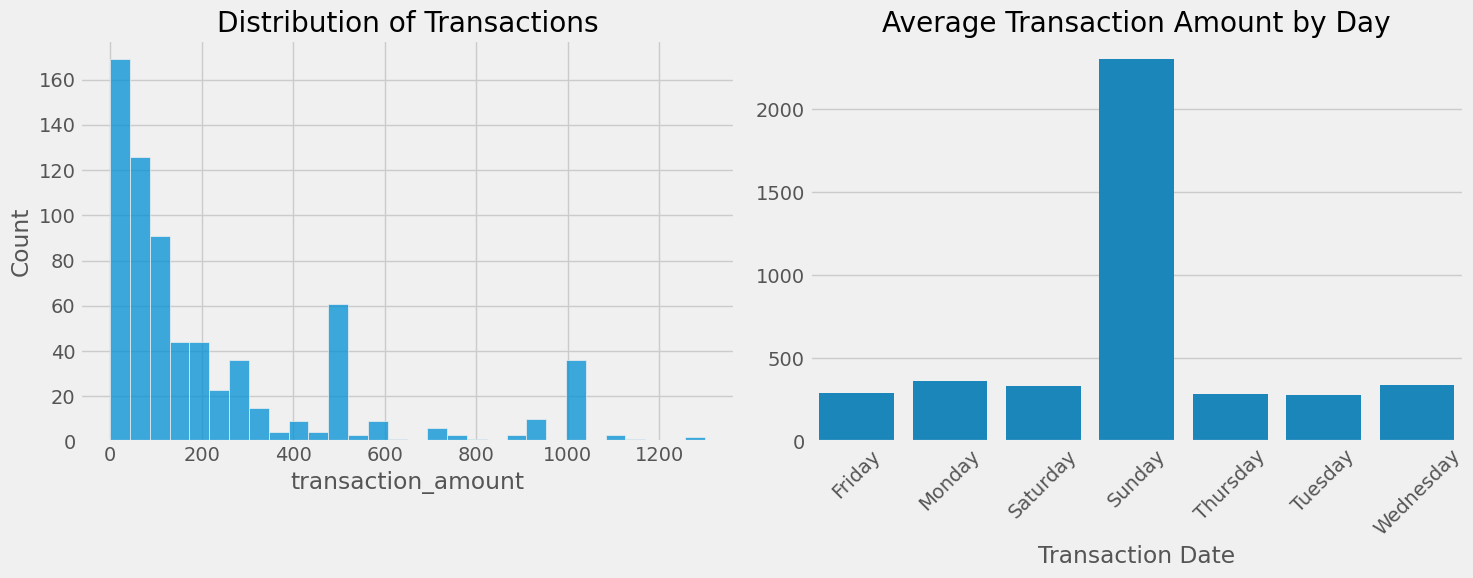

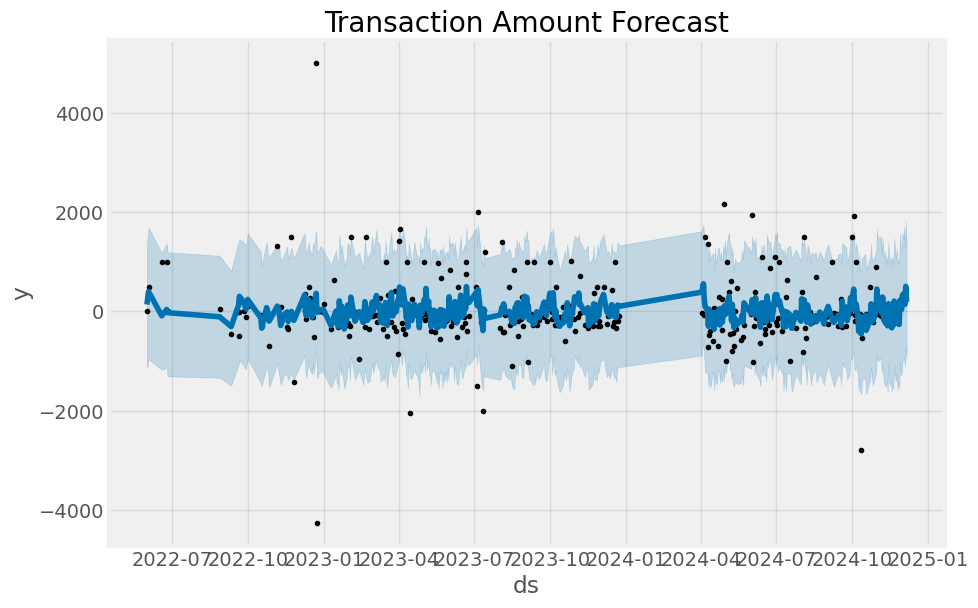

In [26]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def clean_data(df):
    """
    Clean and prepare the transaction data
    """
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    df['Balance'] = df['Balance'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
    df.loc[df['dr_cr_indicator'] == 'CR', 'transaction_amount'] = df.loc[df['dr_cr_indicator'] == 'CR', 'Credit']
    df['signed_amount'] = np.where(df['dr_cr_indicator'] == 'CR',
                                   df['transaction_amount'],
                                   -df['transaction_amount'])
    return df

def create_student_features(df, small, med, high):
    """
    Create features relevant for student transactions
    """
    df['is_small_transaction'] = df['transaction_amount'] <= small
    df['is_medium_transaction'] = (df['transaction_amount'] > small) & (df['transaction_amount'] <= med)
    df['is_large_transaction'] = df['transaction_amount'] > med
    df['is_month_start'] = df['dayofmonth'] <= 5
    df['is_weekend_transaction'] = df['is_weekend'] == 1
    df['daily_transaction_count'] = df.groupby('Transaction Date')['transaction_amount'].transform('count')
    df['daily_spending'] = df.groupby(['Transaction Date', 'dr_cr_indicator'])['transaction_amount'].transform('sum')
    df['7day_avg_spending'] = df.groupby('dr_cr_indicator')['transaction_amount'].transform(
        lambda x: x.rolling(7, min_periods=1).mean())
    df['weekly_transaction_count'] = df.groupby(df['Transaction Date'].dt.isocalendar().week)['transaction_amount'].transform('count')
    df['weekend_spending_ratio'] = df.groupby(df['is_weekend_transaction'])['transaction_amount'].transform('sum') / df['daily_spending'].sum()
    return df

def cluster_transactions(df, high, n_clusters=4):
    """
    Cluster transactions based on student spending patterns
    """
    features_for_clustering = ['transaction_amount', '7day_avg_spending', 'daily_transaction_count', 'is_weekend_transaction', 'is_month_start']
    scaler = StandardScaler()
    cluster_df = df[df['transaction_amount'] <= high].copy()
    scaled_features = scaler.fit_transform(cluster_df[features_for_clustering])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_df['cluster'] = kmeans.fit_predict(scaled_features)
    df['cluster'] = -1  # Default cluster for large transactions
    df.loc[df['transaction_amount'] <= high, 'cluster'] = cluster_df['cluster']
    return df, kmeans

def prepare_prophet_data(df):
    """
    Prepare data for Prophet model
    """
    prophet_df = df.groupby('Transaction Date')['signed_amount'].sum().reset_index()
    prophet_df.columns = ['ds', 'y']
    return prophet_df

def train_student_prophet(prophet_df):
    """
    Train Prophet model with student-relevant parameters
    """
    model = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.05, interval_width=0.95)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(prophet_df)
    return model

def forecast_transactions(model, periods=30):
    """
    Generate future transaction forecasts
    """
    future_dates = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future_dates)
    return forecast

def analyze_student_patterns(df, model, forecast):
    """
    Analyze and visualize student-specific patterns
    """
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df[df['transaction_amount'] <= df['transaction_amount'].quantile(0.95)], x='transaction_amount', bins=30)
    plt.title('Distribution of Transactions')
    plt.subplot(1, 2, 2)
    daily_patterns = df.groupby(df['Transaction Date'].dt.day_name())['transaction_amount'].mean()
    sns.barplot(x=daily_patterns.index, y=daily_patterns.values)
    plt.title('Average Transaction Amount by Day')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    model.plot(forecast)
    plt.title('Transaction Amount Forecast')
    plt.show()

def main(df, small, med, high):
    df = clean_data(df)
    df = create_student_features(df, small, med, high)
    df, kmeans = cluster_transactions(df, high)
    prophet_df = prepare_prophet_data(df)
    model = train_student_prophet(prophet_df)
    forecast = forecast_transactions(model)
    analyze_student_patterns(df, model, forecast)
    return df, forecast, model

# Example usage:
df_processed, forecast, model = main(df, small=600, med=2000, high=5000)
